# Exploratory Analysis & Feature Engineering

This notebook contains an exploratory analysis and feature engineering of the Brazilian E-Commerce Public Dataset by Olist on Kaggle:
www.kaggle.com/datasets/olistbr/brazilian-ecommerce

1. **Load & Merge Data**  
   - Import raw orders and customer tables  
   - Join to associate each order with its unique customer

2. **Clean & Filter**  
   - Convert timestamps and validate data types  
   - Handle missing values (geolocation, review scores, etc.)  
   - Detect and address outliers

3. **Feature Engineering**  
   - **RFM**:  
     - *Recency* (days since last order)  
     - *Frequency* (order count, “returning” flag)  
     - *Monetary* (total spend, log transform)  
   - Additional marketing-relevant features (purchasing power, product popularity score, delivery lateness, etc.)

4. **Exploratory Data Analysis**  
   - Distribution plots, box/violin charts, and correlation heatmaps  
   - Geographic distribution of customers  
   - Justification of transformations and final feature selection

**Output**  
A customer-level dataset that will serve as the input for our segmentation model.

## 1. Set-up Environment and Load Data

In [3]:
# Libraries
import warnings
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from dateutil.relativedelta import relativedelta

# Set-up environment
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="paper")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers/')
print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers


In [4]:
# Load the data
df_features = pd.read_csv("./data/processed/customer_features.csv")
df_customers = pd.read_csv("./data/processed/customers.csv")

# Merging customers onto orders
df_merged = pd.merge(df_features, df_customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  96478 non-null  object 
 1   customer_id               96478 non-null  object 
 2   order_purchase_timestamp  96478 non-null  object 
 3   customer_zip_code_prefix  96478 non-null  int64  
 4   customer_state            96478 non-null  object 
 5   geolocation_lat           96214 non-null  float64
 6   geolocation_lng           96214 non-null  float64
 7   recency_days              96478 non-null  float64
 8   s_delivery_diff           96470 non-null  float64
 9   f_products                96478 non-null  int64  
 10  m_price                   96478 non-null  float64
 11  m_freight                 96478 non-null  float64
 12  s_review_score            95832 non-null  float64
 13  s_review_count            95832 non-null  float64
 14  m_cred

In [5]:
# Extract df for maintenance contract
selected_columns = ['customer_unique_id',
                    'order_purchase_timestamp',
                    'order_id',
                    'm_price'
                   ]

df_maintenance = df_merged[selected_columns]

df_maintenance = df_maintenance.dropna()

df_maintenance.to_csv('./data/processed/df_maintenance.csv', index=False)

## 2. Data Cleaning

**Filter for a 1 year timeframe**

* To avoid data lekage it is necessary to filter to a 1 year timeframe defined as M0.
* 1 year is relevant to account for seasonality. To allow for an analysis of the maintenance contract in notebook 3, we take the max date and subtract 15 months to calculate the start of M0.
* The maintenance contract will be calculated based on the 6 months between the end date of M0 and the max end date of the df.

In [8]:
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])

max_date = df_merged['order_purchase_timestamp'].max()
start    = max_date - relativedelta(months=15)   # 15 months back
end      = max_date - relativedelta(months=3)    # up to 3 months before max

mask = (df_merged['order_purchase_timestamp'] >= start) & \
       (df_merged['order_purchase_timestamp'] <  end)

df_merged = df_merged.loc[mask].copy()

print(f"Start: {start}")
print(f"End: {end}")

Start: 2017-05-29 15:00:37
End: 2018-05-29 15:00:37


**Add Product Category Popularity**

This feature allocates a score to the 73 product categories based on their popularity, which is determined by the recency of their purchase (days since last purchase) and the frequency (count of product_id in order_items). The time scope is 1 year since the most recent purchase date.

In [10]:
df_product_scores = pd.read_csv("./data/processed/product_score_table.csv")

cols = ['recency', 'frequency']
scaler = StandardScaler()
df_product_scores[cols] = scaler.fit_transform(df_product_scores[cols])

a = df_product_scores['recency']
b = df_product_scores['frequency']

df_product_scores['product_score'] = (1 / (1 + a)) + b  # reverse score recency

print(df_product_scores.sort_values('product_score', ascending=False))

# Merge with df_products_raw
df_products_raw = pd.read_csv("./data/processed/product_order_table.csv")

df_product_raw_scored = df_products_raw.merge(
    df_product_scores[['product_category_name', 'product_score']],
    on='product_category_name',
    how='left'
)

# Group by most common category
order_product_code = (
    df_product_raw_scored
      .groupby('order_id')['product_score']
      .agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
      .reset_index()
)

# Merge onto df_merged
df = df_merged.merge(
    order_product_code,
    on='order_id',
    how='left'
)

            product_category_name  frequency  recency  product_score
14                cama_mesa_banho       3.69    -0.42           5.41
12                   beleza_saude       3.39    -0.45           5.20
33                  esporte_lazer       2.64    -0.44           4.43
45         informatica_acessorios       2.56    -0.45           4.37
55               moveis_decoracao       2.45    -0.42           4.18
..                            ...        ...      ...            ...
53      moveis_colchao_e_estofado      -0.58     1.76          -0.22
69       tablets_impressao_imagem      -0.58     2.71          -0.31
38  fashion_roupa_infanto_juvenil      -0.60     2.93          -0.34
18              cds_dvds_musicais      -0.60     4.66          -0.42
47                     la_cuisine      -0.60     4.76          -0.42

[73 rows x 4 columns]


When allocating product category scores to order_ids in the merged_df, there are instances where an order_id is associated with more than one category. The most frequent category in an order is selected, in a few instances, there is no single most frequent category, in which case the most popular category is selected as the default.

In [12]:
# Check instances of multiple categories for an order_id
order_score_counts = (
    df_product_raw_scored
      .groupby('order_id')['product_score']
      .nunique()
      .reset_index(name='n_unique_scores')
)

multi_score_orders = order_score_counts[order_score_counts['n_unique_scores'] > 1]

n_multi = multi_score_orders.shape[0]
total_orders = order_score_counts.shape[0]

print(f"{n_multi} orders out of {total_orders} "
      f"({n_multi/total_orders:.1%}) have more than one product_score.")

786 orders out of 98666 (0.8%) have more than one product_score.


**Replace missing values**
1. Replace geolocation_lat and geolocation_lng outside of Brazil with nan
2. Fill geolocation_lat and geolocation_lng nan with KNN imputer zipcodes

In [14]:
# Replace values outside Brazil's approximate bounds with NaN
df.loc[(df['geolocation_lat'] < -33.75116944) | (df['geolocation_lat'] > 5.27438888), 'geolocation_lat'] = np.nan
df.loc[(df['geolocation_lng'] < -73.98283055) | (df['geolocation_lng'] > -34.79314722), 'geolocation_lng'] = np.nan

# Using KNeighborsRegressor to predict longitude and latitude
df_impute = df[df[['geolocation_lat', 'geolocation_lng']].notna().all(axis=1)].copy()

X = df_impute[['customer_zip_code_prefix']]
y = df_impute[['geolocation_lat', 'geolocation_lng']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

y_pred = knn_reg.predict(X_val)

r2 = knn_reg.score(X_val, y_val)
print("R²:", r2)

# Fill numeric values using the KNN imputer
features = ['customer_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']

imputer = KNNImputer(n_neighbors=5)
df[features] = imputer.fit_transform(df[features])

missing_values_after = df[features].isna().sum()
print("Missing values per column after final KNN imputation:")
print(missing_values_after)

R²: 0.9990272742746735
Missing values per column after final KNN imputation:
customer_zip_code_prefix    0
geolocation_lat             0
geolocation_lng             0
dtype: int64


**Groupby customer_unique_id**

In [16]:
df_fea = (df.groupby('customer_unique_id').agg({
        'order_purchase_timestamp': 'max',    # last purchase
        'order_id':                 'count',  # number of orders
        'f_products':               'sum',    # total items bought
        'm_price':                  'sum',    # total spend
        'm_freight':                'sum',    # total freight
        'm_credit':                 'max',    # ever used credit
        'm_total_installments':     'mean',   # avg installment count
        's_review_score':           'mean',   # avg review
        's_delivery_diff':          'mean',   # avg delivery lateness
        'product_score':            lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'customer_state':           'first',  # static per customer
        'geolocation_lat':          'first',
        'geolocation_lng':          'first',
    }).reset_index()
)

## 3. Feature Engineering

**Recency**

In [19]:
# recency : days since the last purchase
reference_date = pd.to_datetime(df_fea['order_purchase_timestamp']).max()

df_fea['recency'] = (reference_date - pd.to_datetime(df_fea['order_purchase_timestamp'])).dt.days

**Frequency**

In [21]:
# f_returning : Binary variable for returning customers
df_fea.rename(columns={'order_id': 'f_orders'}, inplace=True)
df_fea['f_returning'] = np.where(df_fea['f_orders'] == 1, 0, 1)
df_fea['f_returning'].value_counts()

f_returning
0    63038
1     1766
Name: count, dtype: int64

**Monetary**

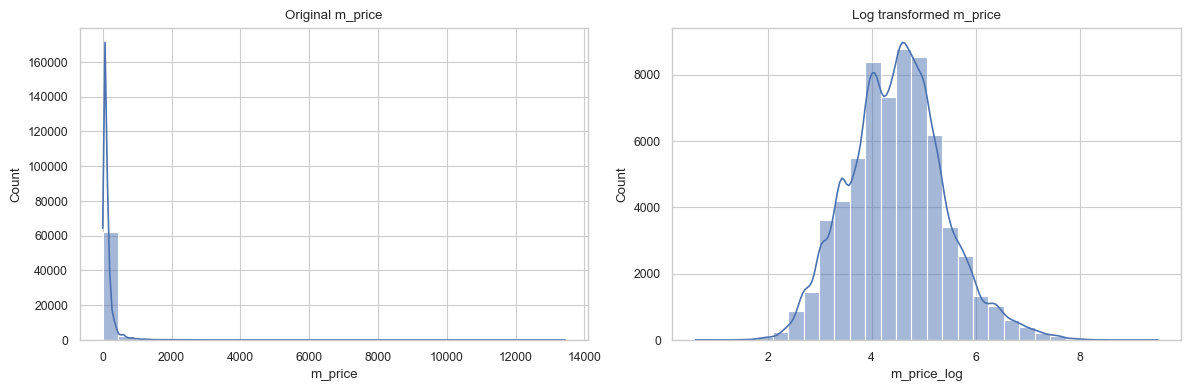

In [23]:
# Log transform total_price
df_fea['m_price_log'] = np.log1p(df_fea['m_price'])

pairs = [('m_price', 'm_price_log')]

for orig, trans in pairs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df_fea[orig], kde=True, bins=30, ax=axes[0])
    axes[0].set_title(f'Original {orig}')
    sns.histplot(df_fea[trans], kde=True, bins=30, ax=axes[1])
    axes[1].set_title(f'Log transformed {orig}')
    plt.tight_layout()
    plt.savefig(f"./plots/eda/log_transformation_{orig}.png")
    plt.show()

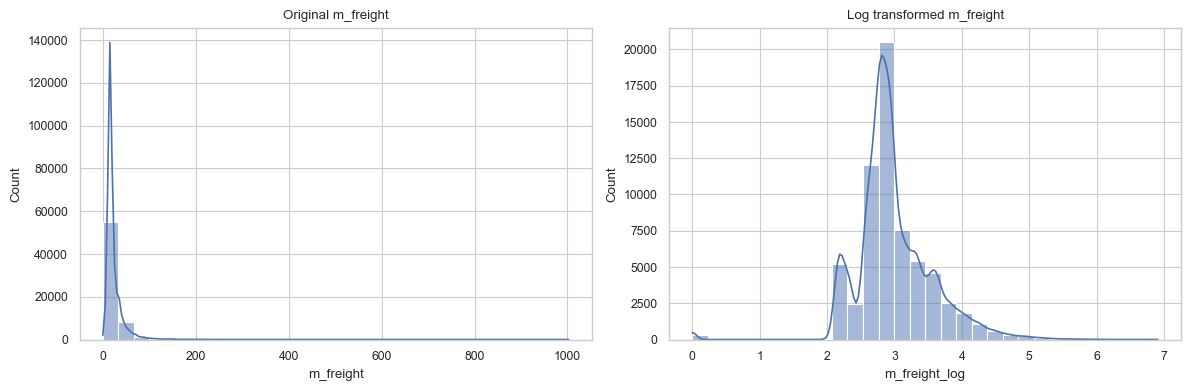

In [24]:
# Log transform total_freight
df_fea['m_freight_log'] = np.log1p(df_fea['m_freight'])

pairs = [('m_freight', 'm_freight_log')]

for orig, trans in pairs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df_fea[orig], kde=True, bins=30, ax=axes[0])
    axes[0].set_title(f'Original {orig}')
    sns.histplot(df_fea[trans], kde=True, bins=30, ax=axes[1])
    axes[1].set_title(f'Log transformed {orig}')
    plt.tight_layout()
    plt.savefig(f"./plots/eda/log_transformation_{orig}.png")
    plt.show()

In [25]:
# m_purchasing_power : highlighting major cities SP and RJ
top_cities = {'SP', 'RJ'}
df_fea['m_purchasing_power'] = df_fea['customer_state'].isin(top_cities).astype(int)

In [26]:
# state_spending : average spending of a state
df_fea['state_spending'] = (df_fea.groupby('customer_state')['m_price'].transform('mean'))

**Satisfaction**

In [28]:
# delivery_diff_grouped : delivery difference between expected and actual [categorical for visualisation]
conditions = [
    df_fea['s_delivery_diff'] <= -7,
    (df_fea['s_delivery_diff'] > -7) & (df_fea['s_delivery_diff'] < 0),
    df_fea['s_delivery_diff'] == 0,
    (df_fea['s_delivery_diff'] > 0) & (df_fea['s_delivery_diff'] < 7),
    df_fea['s_delivery_diff'] >= 7
]

choices = ['Very early', 'Early', 'On time', 'Late', 'Very late']

df_fea['delivery_diff_grouped'] = np.select(conditions, choices, default='On time')

In [29]:
# Replace missing reviews with the average of their delivery_diff_grouped review score
means = df_fea.groupby('delivery_diff_grouped')['s_review_score'].transform('mean')

df_fea['s_review_score'] = df_fea['s_review_score'].fillna(means)

## 4. Exploratory Data Analysis

In [31]:
# Describe numeric features
features = [
    col for col in df_fea.columns
    if col not in ['geolocation_lat', 'geolocation_lng']
    and df_fea[col].dtype in ('int64','float64')
]

df_fea[features].describe()

,f_orders,f_products,m_price,m_freight,m_credit,m_total_installments,s_review_score,s_delivery_diff,product_score,recency,f_returning,m_price_log,m_freight_log,m_purchasing_power,state_spending
count,64804.00,64804.00,64804.00,64804.00,64804.00,64804.00,64804.00,64803.00,64803.00,64804.00,64804.00,64804.00,64804.00,64804.00,64804.00
mean,1.03,1.18,139.98,23.03,0.77,2.97,4.10,-10.20,3.30,156.17,0.03,4.49,2.99,0.54,139.98
std,0.20,0.62,204.35,21.86,0.42,2.72,1.31,9.63,1.41,98.99,0.16,0.92,0.57,0.50,14.45
min,1.00,1.00,0.85,0.00,0.00,0.00,1.00,-146.02,-0.42,0.00,0.00,0.62,0.00,0.00,128.79
25%,1.00,1.00,48.00,13.86,1.00,1.00,4.00,-15.19,2.26,72.00,0.00,3.89,2.70,0.00,128.99
50%,1.00,1.00,89.20,17.00,1.00,2.00,5.00,-11.21,2.90,144.00,0.00,4.50,2.89,1.00,139.26
75%,1.00,1.00,152.00,25.25,1.00,4.00,5.00,-6.30,4.43,231.00,0.00,5.03,3.27,1.00,146.57
max,10.00,21.00,13440.00,1002.29,1.00,26.00,5.00,188.98,5.41,364.00,1.00,9.51,6.91,1.00,215.76


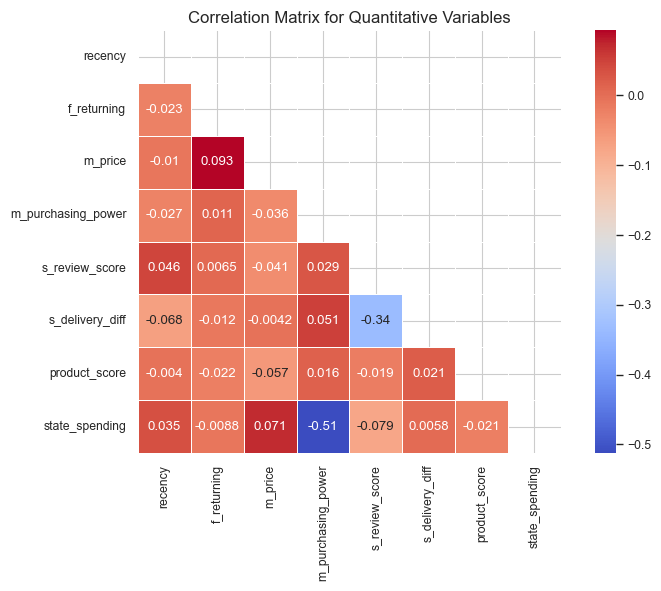

In [32]:
# Correlation matrix
features = ['recency',
            'f_returning',
            'm_price', 'm_purchasing_power',
            's_review_score', 's_delivery_diff',
            'product_score', 'state_spending']

corr = df_fea[features].corr()

# Plot
mask = np.triu(corr)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask, linewidths=.5, cbar=True, square=True)
plt.title("Correlation Matrix for Quantitative Variables", fontsize=12)
plt.tight_layout()
plt.savefig(f"./plots/eda/Correlation_Matrix_for_Quantitative_Variables.png", dpi=300)
plt.show()

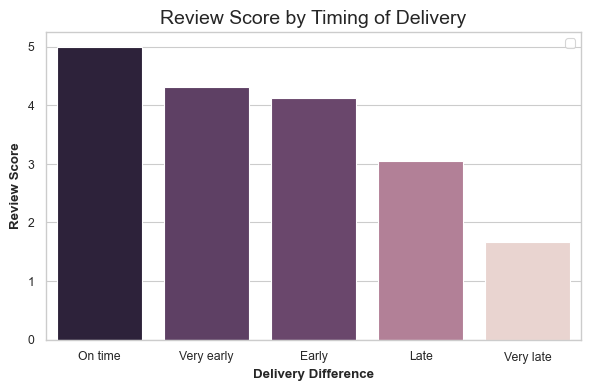

In [33]:
# Review Score by Timing of Delivery
check = df_fea.groupby(['delivery_diff_grouped']).agg({
    's_review_score': 'mean'})

check = check.sort_values('s_review_score', ascending=False).reset_index().round(2)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(y='s_review_score', x='delivery_diff_grouped', hue='s_review_score', data=check)
plt.title('Review Score by Timing of Delivery', fontsize=14)
plt.xlabel('Delivery Difference', fontweight='bold')
plt.ylabel('Review Score', fontweight='bold')
plt.legend('')
plt.tight_layout()
plt.savefig(f"./plots/eda/Review_Score_by_Timing_of_Delivery.png", dpi=300)
plt.show()

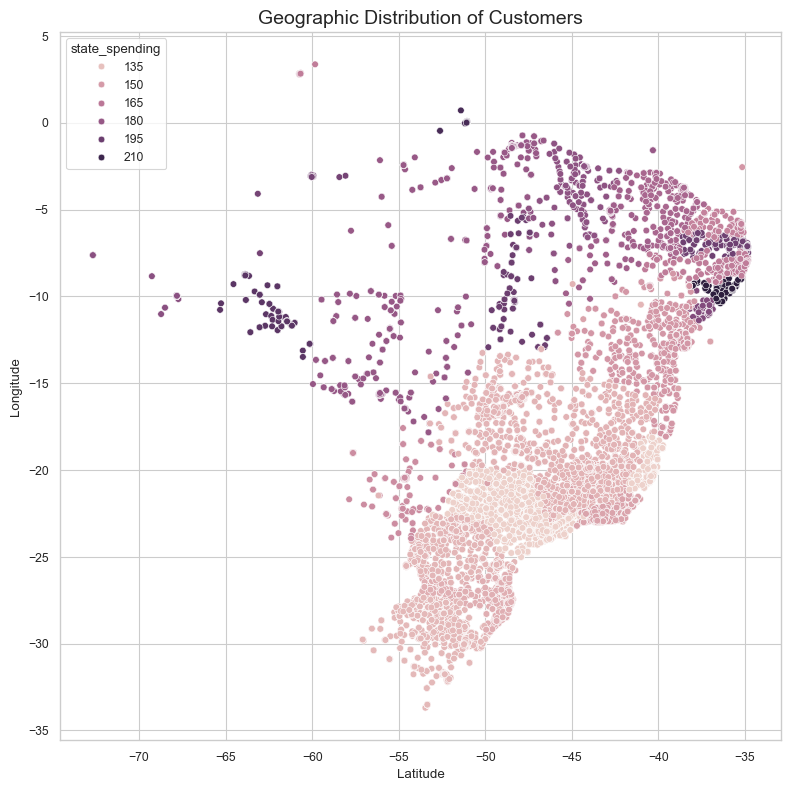

In [34]:
# Geographic spread of customers
plt.figure(figsize=(8,8))
sns.scatterplot(data=df_fea, y='geolocation_lat', x='geolocation_lng', hue='state_spending')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Geographic Distribution of Customers", fontsize=14)
plt.tight_layout()
plt.savefig(f"./plots/eda/Geographic_Distribution_of_Customers.png", dpi=300)
plt.show()

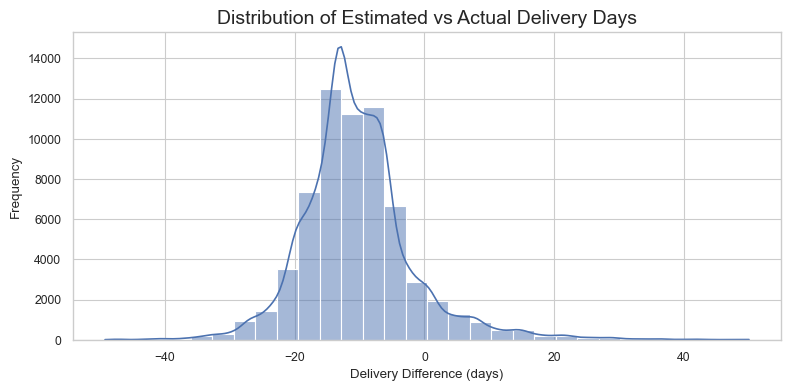

In [35]:
# Distribution of Delivery Difference
df_plot = df_fea[df_fea['s_delivery_diff'].between(-50, 50)]
plt.figure(figsize=(8,4))
sns.histplot(df_plot['s_delivery_diff'], bins=30, kde=True)
plt.xlabel("Delivery Difference (days)")
plt.ylabel("Frequency")
plt.title("Distribution of Estimated vs Actual Delivery Days", fontsize=14)
plt.tight_layout()
plt.savefig(f"./plots/eda/Distribution_of_Estimated_Actual_Delivery_Days.png", dpi=300)
plt.show()

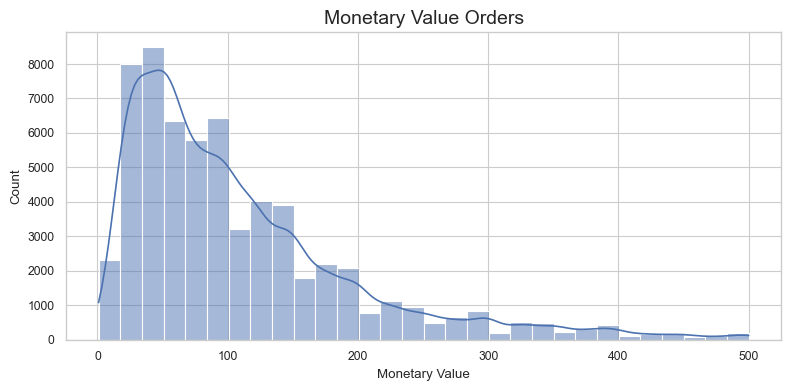

In [36]:
# Distribution of monetary value
df_plot = df_fea[df_fea['m_price'] < 500]
plt.figure(figsize=(8,4))
sns.histplot(df_plot['m_price'], bins=30, kde=True)
plt.xlabel("Monetary Value")
plt.ylabel("Count")
plt.title("Monetary Value Orders", fontsize=14)
plt.tight_layout()
plt.savefig(f"./plots/eda/Monetary_Value_Orders.png", dpi=300)
plt.show()

## 5. Export

In [38]:
selected_columns = ['customer_unique_id',
                    'order_purchase_timestamp',
                    'recency',
                    'f_returning',
                    'm_price',
                    'm_price_log', 
                    'm_purchasing_power',
                    'state_spending',
                    'm_total_installments',
                    'product_score',
                    's_review_score',
                    's_delivery_diff',
                   ]

df_selected = df_fea[selected_columns]

df_selected = df_selected.dropna()

df_selected.to_csv('./data/processed/processed_database.csv', index=False)

df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64802 entries, 0 to 64803
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        64802 non-null  object        
 1   order_purchase_timestamp  64802 non-null  datetime64[ns]
 2   recency                   64802 non-null  int64         
 3   f_returning               64802 non-null  int64         
 4   m_price                   64802 non-null  float64       
 5   m_price_log               64802 non-null  float64       
 6   m_purchasing_power        64802 non-null  int64         
 7   state_spending            64802 non-null  float64       
 8   m_total_installments      64802 non-null  float64       
 9   product_score             64802 non-null  float64       
 10  s_review_score            64802 non-null  float64       
 11  s_delivery_diff           64802 non-null  float64       
dtypes: datetime64[ns](1), f